# Preparing the environment

## Graphics and plotting

The following block of code initializes the Python plotting library [matplotlib](http://matplotlib.org/gallery.html) and configures it to show figures embedded in the notebook (as opposed to opening a new window for each figure):

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

The Seaborn library provides easy-to-use plotting functions for common plot types, and better default visual styles.

In [3]:
import seaborn as sea

Set the default size and style of the plot.  (Plots are styled to [look like R's `ggplot`](http://tonysyu.github.io/mpltools/auto_examples/style/plot_ggplot.html) library.)

In [4]:
matplotlib.rcParams['figure.figsize'] = (10, 7)

sea.set_style('dark')

## SQL database connection

The ESC493 VM comes preinstalled with [Catherine Devlin's `%sql`-magic for IPython][1]; this allows you to run SQL queries from the IPython notebook, and intermix them with Python code.

[1]: https://github.com/catherinedevlin/ipython-sql

Before we can use the `%sql` syntax, two steps must be taken:

* Load the IPython-SQL bridge code

In [5]:
%load_ext sql

* Connect to an actual database; this must be the first `%sql` statement (the `rmurri@/lustre` syntax means "connect to the PostGreSQL DB named `lustre` running on *this* host as user `rmurri`" -- of course change `rmurri` to *your* user name):

In [6]:
%sql postgresql://muesim@/lustre


u'Connected: muesim@lustre'

Now you can run 1-line SQL queries by prefixing them with `%sql` or multi-line ones with `%%sql`

# Exploring the dataset

In [7]:
%sql select * from lustre_sample limit 5;

5 rows affected.


usr,grp,atime,mtime,blksize,size,path
usr388,i5105,1392320637,1392320637,56,56351,/scratch/bioc/usr388/Vina_5wat/out/ZINC72133399_out.pdbqt
usr388,i5105,1392323786,1392323786,56,56351,/scratch/bioc/usr388/Vina_5wat/out/ZINC04653765_out.pdbqt
usr388,i5105,1392311833,1392311833,48,46751,/scratch/bioc/usr388/Vina_5wat/out/ZINC56958837_out.pdbqt
usr388,i5105,1392319655,1392319655,44,43811,/scratch/bioc/usr388/Vina_5wat/out/ZINC06788899_out.pdbqt
usr388,i5105,1392323946,1392323946,60,57691,/scratch/bioc/usr388/Vina_5wat/out/ZINC67843055_out.pdbqt


The `%sql` "magic" can also be used as an expression: it returns the result table as a Python `list` of tuples:

In [8]:
%%time

result = %sql select size, count(path) from lustre_sample group by size order by size asc limit 100;

100 rows affected.
CPU times: user 1.98 ms, sys: 4.28 ms, total: 6.26 ms
Wall time: 2.91 s


Now the `result` list can be used in code as if we had defined it in Python directly:

In [9]:
result[:5]

[(0L, 12722L), (1L, 15L), (2L, 20L), (3L, 2L), (4L, 43L)]

## Plotting results

In order to plot results, we need to have separate lists/arrays for the X-axis values and the corresponding Y-axis values.


Python's `zip` function is used to split the result table into independent lists (all first elements, all second elements):

In [10]:
sizes, occurrences = zip(*result)

In [11]:
sizes[:5], occurrences[:5]

((0L, 1L, 2L, 3L, 4L), (12722L, 15L, 20L, 2L, 43L))

The `plt.plot()` function is used to make a line plot; here we show how to place "sizes" on the X-axis and "occurrences" on the Y-axis:

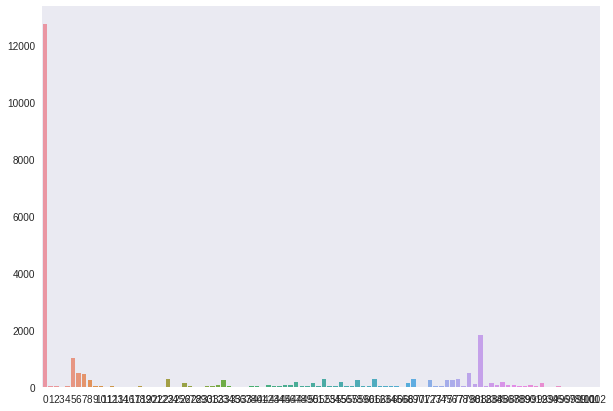

In [11]:
sea.barplot(sizes, occurrences)

---

## 1. Plot distribution by block size

Plot the number of files of a certain *block size* (column `blksize`).  The *block size* is the actual size allocated on the disk, measured in blocks (size depends on the filesystem -- here 1 block is 1MB).

100 rows affected.
CPU times: user 706 ms, sys: 70 µs, total: 706 ms
Wall time: 1.26 s


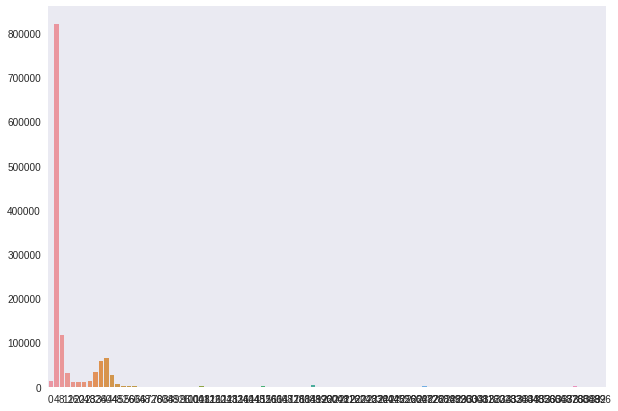

In [9]:
%%time

result = %sql select blksize, count(path) from lustre_sample group by blksize order by blksize asc limit 100;
blksizes, occurances = zip(*result)
sea.barplot(blksizes, occurances)

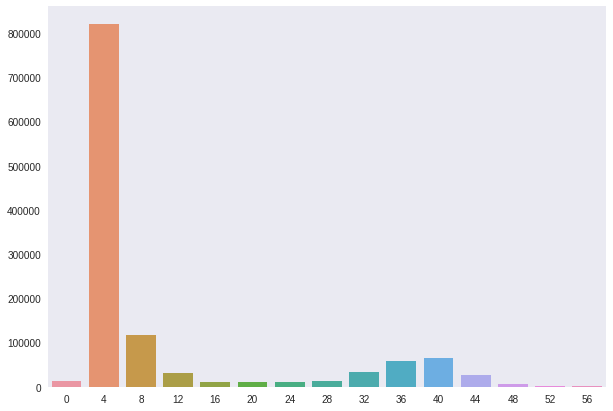

In [43]:
blksizes_1, occurances_1 = blksizes[:15], occurances[:15]
sea.barplot(blksizes_1, occurances_1)

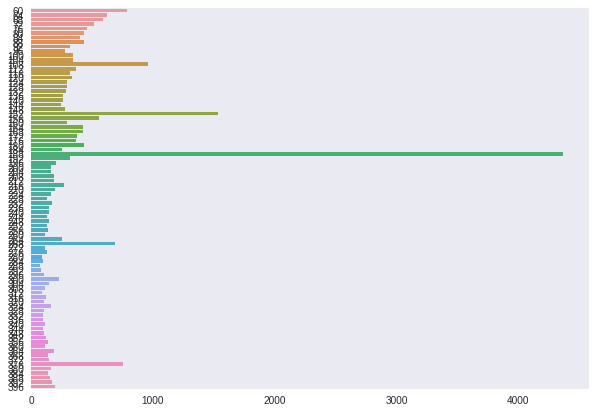

In [45]:
blksizes_2, occurances_2 = blksizes[15:], occurances[15:]
sea.barplot(occurances_2, blksizes_2, orient='h')

## 2. Plot number of users by number of (owned) files

For each user *u*, let *N(u)* be the number of files owned by user *u*.  For each integer *K*, compute and plot the number of users *u* such that *N(u) = K*.

40 rows affected.
CPU times: user 191 ms, sys: 0 ns, total: 191 ms
Wall time: 610 ms


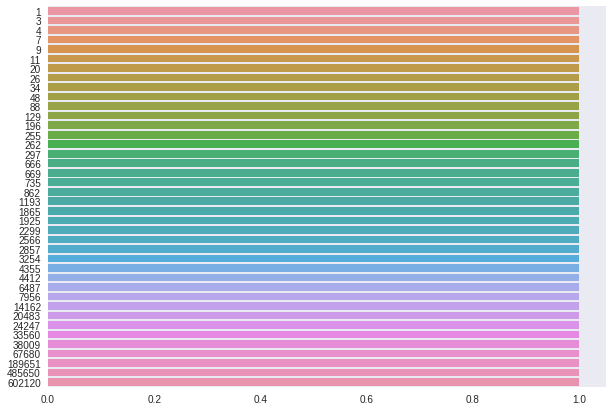

In [47]:
%%time
result = %sql select usr, count(path) from lustre_sample group by usr order by count(path) asc;
usr, occurences = zip(*result)
temp = []
for K in occurences:
    temp.append(occurences.count(K))
sea.barplot(temp, occurences, orient='h')

In [ ]:
# Alternative way to do it using only SQL queries
result = %sql SELECT sub.cnt, COUNT(sub.usr) FROM (SELECT usr, COUNT(path) AS cnt FROM lustre_sample GROUP BY usr) AS sub GROUP BY sub.cnt ORDER BY sub.cnt ASC;

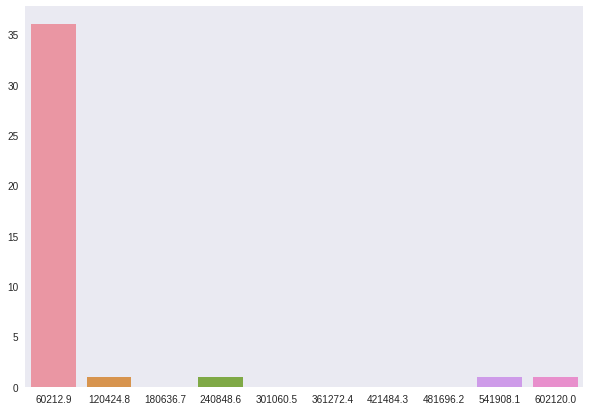

In [49]:
import numpy as np
hist, bin_edges = np.histogram(occurences)
# If we have n bins we will get n + 1 edges
sea.barplot(bin_edges[1:], hist)
#or: sea.barplot(bin_edges[:-1], hist)

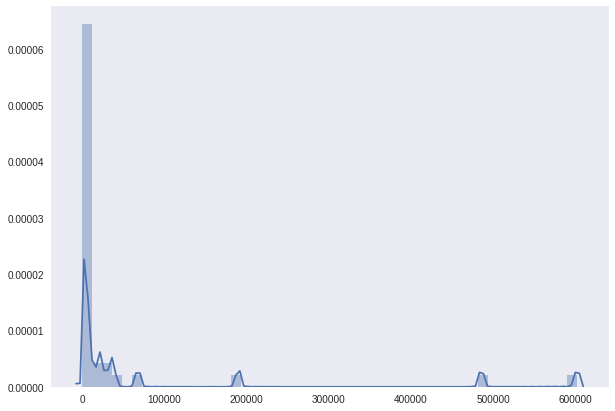

In [50]:
sea.distplot(np.array(occurences))
# The line is the kernel function estimate